In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random
import sys
sys.path.append('../')
from Core_Functions import neural_networks, generate_image_set

Using TensorFlow backend.


In [4]:
# Load data and split into training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

In [6]:
combo_train_X, combo_train_y = generate_image_set.get_image_combinations(40000, X_train, y_train)
combo_val_X, combo_val_y = generate_image_set.get_image_combinations(20000, X_val, y_val)

combo_test_X, combo_test_y = generate_image_set.get_image_combinations(10000, test_images, test_labels)

In [7]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 56, 1))
train_images = train_images/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 56, 1))
val_images = val_images/255

test_images = combo_test_X.reshape((combo_test_X.shape[0], 28*56,))
test_images = test_images/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

test_labels = to_categorical(combo_test_y)

In [8]:
model = neural_networks.build_CNN((28, 56, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [17]:
# Perform k-fold cross-validation to understand the optimal number of epochs to train on
k = 2
num_val_samples = len(train_images)//k

num_epochs = 50

all_val_mae_histories = []
all_train_mae_histories = []

all_val_acc_histories = []
all_train_acc_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = neural_networks.build_CNN((28, 56, 1))
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    all_val_mae_histories.append(val_mae_history)
    
    train_mae_history = history.history['mae']
    all_train_mae_histories.append(train_mae_history)
    
    val_acc_history = history.history['val_accuracy']
    all_val_acc_histories.append(val_acc_history)
    
    train_acc_history = history.history['accuracy']
    all_train_acc_histories.append(train_acc_history)

processing fold # 0
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 1
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])


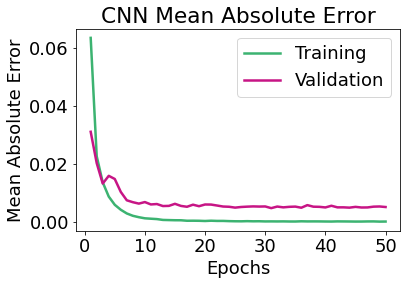

In [46]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

average_train_mae_history = [
    np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_train_mae_history) + 1), average_train_mae_history, label = 'Training', c ='mediumseagreen', lw=2.5)
plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, label='Validation', c = 'mediumvioletred', lw=2.5)

plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.title('CNN Mean Absolute Error')
plt.savefig('Q1_Figures/Q1_CNN_MAE.png', dpi = 400, bbox_inches="tight")

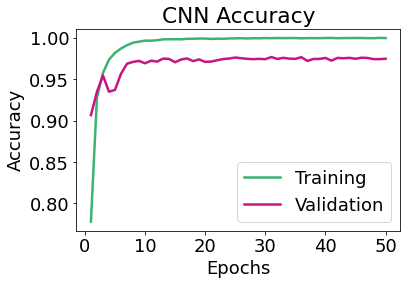

In [45]:
# Compute the average of the per-epoch Accuracy scores for all folds
# Building the history of successive mean K-fold validation scores

average_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

average_train_acc_history = [
    np.mean([x[i] for x in all_train_acc_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_train_acc_history) + 1), average_train_acc_history, label = 'Training', c ='mediumseagreen', lw=2.5)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history, label='Validation', c = 'mediumvioletred', lw=2.5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.title('CNN Accuracy')
plt.savefig('Q1_Figures/Q1_CNN_Accuracy.png', dpi = 400, bbox_inches="tight")

In [11]:
# Rebuild the model and train on full dataset (60k) rather than splitting it (48k)
# Do this for the optimal number of epochs
    # It seems like around 20 epochs the validation MAE and Accuracy flatten, so this will be used
model = neural_networks.build_CNN((28, 56, 1))
model.fit(train_images, train_labels, epochs = 20, batch_size = 64)

Epoch 1/20
625/625 [==============================] - 28s 43ms/step - loss: 0.4359 - accuracy: 0.8593 - mae: 0.0418
Epoch 2/20
625/625 [==============================] - 30s 48ms/step - loss: 0.1275 - accuracy: 0.9596 - mae: 0.0126
Epoch 3/20
625/625 [==============================] - 32s 52ms/step - loss: 0.0730 - accuracy: 0.9775 - mae: 0.0072
Epoch 4/20
625/625 [==============================] - 38s 61ms/step - loss: 0.0475 - accuracy: 0.9847 - mae: 0.0047
Epoch 5/20
625/625 [==============================] - 48s 77ms/step - loss: 0.0329 - accuracy: 0.9893 - mae: 0.0032
Epoch 6/20
625/625 [==============================] - 38s 61ms/step - loss: 0.0241 - accuracy: 0.9921 - mae: 0.0024
Epoch 7/20
625/625 [==============================] - 31s 50ms/step - loss: 0.0172 - accuracy: 0.9944 - mae: 0.0017
Epoch 8/20
625/625 [==============================] - 30s 48ms/step - loss: 0.0145 - accuracy: 0.9953 - mae: 0.0014
Epoch 9/20
625/625 [==============================] - 42s 67ms/step - lo

In [12]:
test = model.evaluate(test_images, test_labels)
test

ValueError: in user code:

    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1323 test_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1307 run_step  **
        outputs = model.test_step(data)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1266 test_step
        y_pred = self(x, training=False)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 1568)


In [ ]:
# Verify above by visually inspecting images from the predicted set
num_val_images = 10000

# Run this cell repeatedly to see multiple examples
check_index = random.randint(0,num_val_images)
plt.imshow(val_images[check_index].reshape(28,56), cmap = plt.cm.binary)
print("Predicted: " + str(np.argmax(y_predict[check_index])))
print("True: " + str(np.argmax(val_labels[check_index])))
#plt.savefig('Q1_Figures/Q1_Example_Image_' + str(check_index) + '.png', dpi = 400, bbox_inches="tight")

In [45]:
# serialize model to JSON
model_json = model.to_json()
with open("Q1_Trained_Models/CNN_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Q1_Trained_Models/CNN_Model.h5")
print("Saved model to disk")

Saved model to disk
